# Automatic Segmentation of Sentinel-2

This notebook demonstrates how to automatically segment Sentinel-2 imagery, using a FarmVibes.AI workflow that leverages [Segment Anything Model](https://github.com/facebookresearch/segment-anything) (SAM). **We currently only support Unix-based systems (Linux and MacOS) for running this notebook.**

### **Automatic Segmentation** vs. **Prompt-based segmentation**
Differently from [sentinel2_segmentation.ipynb](./sentinel2_automatic_segmentation.ipynb), this notebook uses the automatic segmentation workflow, which allows the segmentation of multiple elements in a raster without requiring user-defined prompts (i.e., points or bounding boxes marking elements of interest). Behind the scenes, it samples several points in a grid throughout the raster and use them as prompts for intermediary segmentation processes. All intermediary masks are, then, filtered and combined into a final set of masks (one for each entity). 

The flexibility of identifying multiple elements in the raster without defining a set of prompts comes with an increase in computing and disk space consumption due to multiple segmentation iterations. Additionally, the output set of masks may not be as refined as the masks obtained from a prompt-based segmentation, because the latter allows a higher control through foreground and background prompts, and consequently yields higher quality masks for individual elements. 


### Notebook Organization

The notebook is divided into the following sections:

1. **Environment setup**: this section provides instructions for setting up the micromamba environment for FarmVibes.AI and importing the necessary libraries for the notebook. We also download and export the ONNX files required to run SAM workflows to our cluster.

2. **Workflow setup**: we define a location and time range of interest for our analysis.

3. **Running the workflow**: this section discusses the parameters of the SAM workflow and demonstrates how to run it.

4. **Visualizing the results**: finally, we visualize the results of the workflow.

We run steps 3 and 4 for a few different parameter combinations to demonstrate the effect of the parameters on the results.


### Importing SAM's ONNX models to the cluster

Before running SAM workflows in FarmVibes.AI, we need to add the model to our cluster. We provide a script that downloads the original weights from the [official repository](https://github.com/facebookresearch/segment-anything) and separately converts the image encoder and prompt encoder + mask decoder to ONNX format. The script also adds the ONNX models to our cluster, allowing them to be used in workflows.

**If you are importing the ONNX files to your cluster for the first time**, make sure the following environment is configured:

```bash
$ micromamba env create -f env_cpu.yaml
$ micromamba activate segment_anything_cpu
```

With the environment activated, execute the following command **in the repository root**:

```bash
$ python scripts/export_sam_models.py --models <model_types>
```

where `<model_types>` is a list of model types to be exported (`vit_b`, `vit_l`, `vit_h`). For example, to export all three ViT backbones, run:

```bash
$ python scripts/export_sam_models.py --models vit_b vit_l vit_h
```

In this notebook, we will export the `vit_b` model:

In [ ]:
! python ../../scripts/export_sam_models.py --models vit_b

### Imports

**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ micromamba activate farmvibes-ai
```

Let's start the notebook by importing the necessary libraries:

In [1]:
from datetime import datetime

from notebook_lib.utils import color_autoseg_masks, plot_autoseg_masks
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client

## Workflow setup

Let's understand the tasks and parameters of the Automatic Segmentation workflow. To do so, let's instantiate our client and document the workflow that we will use in this notebook:

In [2]:
client = get_default_vibe_client()
client.document_workflow("farm_ai/segmentation/auto_segment_s2")

Workflow: farm_ai/segmentation/auto_segment_s2

Description:

Downloads Sentinel-2 imagery and runs Segment Anything Model (SAM) automatic segmentation over  
    them. The workflow retrieves the relevant Sentinel-2 products with the Planetary Computer (PC)  
    API, and splits the input rasters into chips of 1024x1024 pixels with an overlap defined by     
    `spatial_overlap`. Each chip is processed by SAM's image encoder, and a point grid is defined   
    within each chip, with each point being used as a prompt for the segmentation. Each point is    
    used to generate a mask, and the masks are combined using multiple non-maximal suppression steps
    to generate the final segmentation mask. Before running the workflow, make sure the model has   
    been imported into the cluster by running `scripts/export_prompt_segmentation_models.py`. The   
    script will download the desired model weights from SAM repository, export the image encoder and
    mask decoder to ONNX format, and add them to the cluster. For more information, refer to the    
    [FarmVibes.AI                                                                                   
    troubleshooting](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/TROUBLESHOOTING.html
    ) page in the documentation.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- s2_raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 rasters used as input for the 
    segmentation.

- segmentation_mask (vibe_core.data.rasters.CategoricalRaster): Output segmentation masks.

Parameters:

- pc_key (default: ): Optional Planetary Computer API key.

- model_type (default: vit_b): SAM's image encoder backbone architecture, among 'vit_h',        
    'vit_l', or 'vit_b'. Before running the workflow, make sure the desired model has been exported 
    to the cluster by running `scripts/export_sam_models.py`. For more information, refer to the    
    FarmVibes.AI troubleshooting page in the documentation.

- spatial_overlap (default: 0.5): Percentage of spatial overlap between chips in the range of   
    [0.0, 1.0).

- points_per_side (default: 16): The number of points to be sampled along one side of the chip  
    to be prompts. The total number of points is points_per_side**2.

- n_crop_layers (default: 0): If >0, mask prediction will be run again on crops of the image.   
    Sets the number of layers to run, where each layer has 2**i_layer number of image crops.

- crop_overlap_ratio (default: 0.0): Sets the degree to which crops overlap. In the first crop  
    layer, crops will overlap by this fraction of the chip length. Later layers with more crops     
    scale down this overlap.

- crop_n_points_downscale_factor (default: 1): The number of points-per-side sampled in layer n 
    is scaled down by crop_n_points_downscale_factor**n.

- pred_iou_thresh (default: 0.88): A filtering threshold in [0,1] over the model's predicted    
    mask quality/score.

- stability_score_thresh (default: 0.95): A filtering threshold in [0,1], using the stability of
    the mask under changes to the cutoff used to binarize the model's mask predictions.

- stability_score_offset (default: 1.0): The amount to shift the cutoff when calculated the     
    stability score.

- points_per_batch (default: 16): Number of points to process in a single batch.

- num_workers (default: 0): Number of workers to use for parallel processing.

- in_memory (default: True): Whether to load the whole raster in memory when running            
    predictions. Uses more memory (~4GB/worker) but speeds up inference for fast models.

- chip_nms_thr (default: 0.7): The box IoU cutoff used by non-maximal suppression to filter     
    duplicate masks within a chip.

- mask_nms_thr (default: 0.5): The box IoU cutoff used by non-maximal suppression to filter     
    duplicate masks between different chips.

Tasks:

- preprocess_s2: Downloads and preprocesses Sentinel-2 imagery that covers the input geometry   
    and time range.

- s2_automatic_segmentation: Runs a Segment Anything Model (SAM) automatic segmentation over    
    Sentinel-2 rasters.

### Understanding the main parameters of the automatic segmentation

The `farm_ai/segmentation/auto_segment_s2` has a single input, which is the geometry and time range of interest. It will download Sentinel-2 raster data for the specified region and time range, and segment the raster using the SAM model. The output is a [`CategoricalRaster`](https://microsoft.github.io/farmvibes-ai/docfiles/code/vibe_core_data/rasters.html#vibe_core.data.rasters.CategoricalRaster) with the segmentation results.

The workflow has two tasks (`data_ingestion/sentinel2/preprocess_s2` and `ml/segment_anything/s2_auto_segmentation`). The `preprocess_s2` task downloads the Sentinel-2 raster data, which is forwareded to the `s2_auto_segmentation` task that segments each element and combines the results into a single mask raster.

As for parameters, the main ones related to the segmentation process of the `s2_auto_segmentation` task are:

- `model_type`: defines the backbone architecture for SAM's image encoder, among `vit_b`, `vit_l`, and `vit_h`. The default value is `vit_b`.
- `spatial_overlap`: the input raster is split into chips of size 1024x1024 pixels. This parameter defines the spatial overlap between chips in the segmentation process. The default value is 0.5, meaning that the chips will overlap by 50%. Increasing this parameter allows the segmentation of elements that may fall in the border of two chips, but also increases computation, as more chips will be processed.
- `points_per_side`: determines the size of the point grid sampled for each chip, i.e. the number of points to be sampled along one side of the chip to be used as prompts. The total number of points in a grid is `points_per_side**2`. The default value is 16, and increasing this parameter allows the model to capture smaller elements within the chip (as we increase the chance of a point being sampled within that element).
- `n_crop_layers`: if greater than 0, the segmentation process will be run on crops of the chip. This parameter sets the number of layers to run, where each layer has `2**i_layer` number of image crops. For example, with `n_crop_layers=0` the segmentation is run solely on each chip. With `n_crop_layers=1`, besides the each chip, the segmentation is also run in 4 smaller crops (2 by 2) per chip, and so on. The masks obtained across all crops are combined. By operating on smaller images as well, this parameter allows the model to capture more details and improve the segmentation quality, at the cost of increased computation. The default value is 0 (i.e., only runs the segmentation on the whole chip).
- `crop_overlap_ratio`: sets the degree to which crops overlap. This is similar to the `spatial_overlap` parameter, but with respect to crops (defined by the `n_crop_layers` parameter). The default value is 0.0.
- `crop_n_points_downscale_factor`: the number of points sampled in each layer is scaled down by this factor. The number of points-per-side sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`. The default value is 1 (i.e., no downscaling, the same number of points is sampled in each layer).
- `pred_iou_thresh`: a filtering threshold in the range of [0,1] over the model's predicted mask quality/score. This is used to remove masks which SAM assigns a low quality/confidence score. The default value is 0.88.
- `stability_score_thresh`: a filtering threshold in the range of [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions. This is used to remove masks that vary considerably due to small changes in the binarization threshold. The default value is 0.95.
- `stability_score_offset`: the amount to shift the binarization cutoff when calculating the stability score. The default value is 1.0.
- `points_per_batch`: the number of points to process in a single batch. The default value is 16.

Additionally, there are two parameters related to the filtering and combination of masks:

- `chip_nms_thr`: the box IoU cutoff used by non-maximal suppression to filter duplicate masks within a chip. Decreasing this threshold means that masks in the same chip that share lower IoUs might be filtered out from the final mask. Whereas higher cutoffs allows masks that share higher IoU with other masks to be considered for the output. The default value is 0.7.
- `mask_nms_thr`: the box IoU cutoff used by non-maximal suppression to filter duplicate masks between different chips. This is similar to `chip_nms_thr`, but applied across chips. The default value is 0.5.

## Running the workflow

Now that we understand the parameters of the workflow, let's run it on a small region. In this example, we select an area around a defined latitude/longitude and a time range of a few days. 

In [3]:
geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(0.07, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

We will instantiate a workflow run and monitor its progress:

In [4]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 8,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

Output()

The output of the segmentation is a raster containing a mask with the same size as the input RoI, with each channel corresponding to one identified entity. 

The values of the mask are 0 (background) or 1 (foreground) and we can visualize them by plotting each channel with a different color.

We provide two auxiliary functions to help us visualize the masks: `color_autoseg_masks` and `plot_autoseg_masks`:

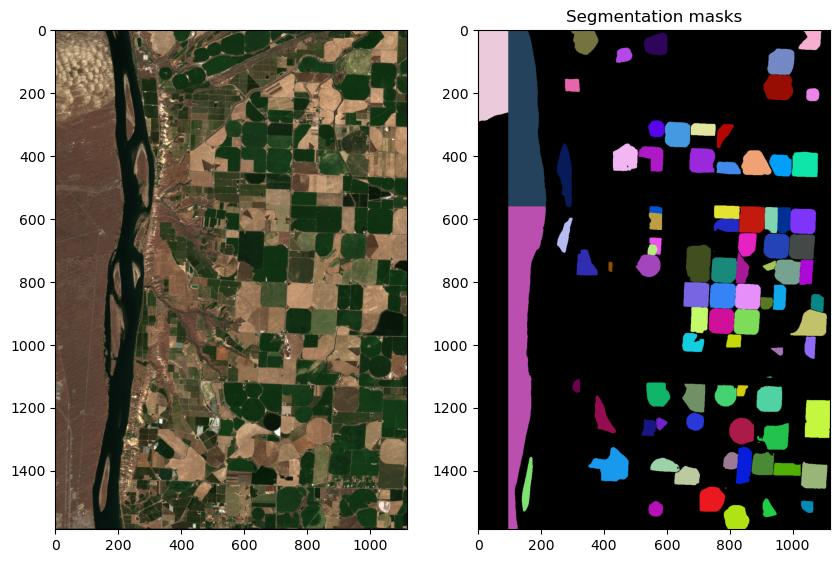

In [5]:
# Read and combine the masks into a single RGB numpy array for visualization
colored_mask = color_autoseg_masks(run.output["segmentation_mask"][0])

# Plot the Sentinel-2 raster and the colored masks
plot_autoseg_masks(run.output["s2_raster"][0], {"Segmentation masks": colored_mask}, geom)

As we can see, the workflow is able to capture several fields on the right portion of the region, but there are still several missing ones in the output segmentation mask.

One way to improve these results is increasing the number of crop layers, with the `n_crop_layers` parameter. This will allow the model to run the segmentation over smaller crops within input region, which can help it capture more details and improve the segmentation quality, at the cost of increased computation.

With `n_crop_layers=1`, the segmentation is run on 4 smaller crops (2 by 2) per chip, and all intermediary masks (each original chip and all crops) are combined. Let's run the workflow again with this parameter:


Output()

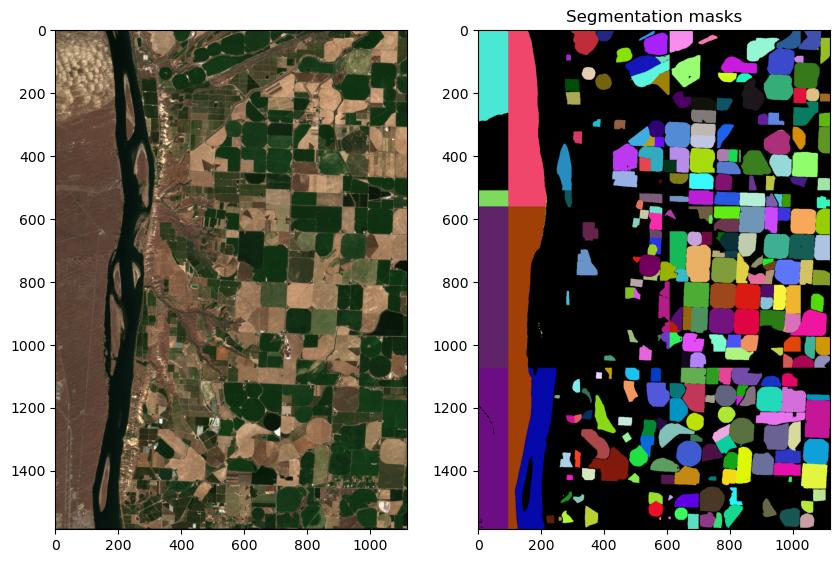

In [6]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 8,
        "spatial_overlap": 0.0,
        "n_crop_layers": 1,
    },
)
run.monitor()

seg_mask_8pps_1croplayer = color_autoseg_masks(run.output["segmentation_mask"][0])

plot_autoseg_masks(
    run.output["s2_raster"][0], {"Segmentation masks": seg_mask_8pps_1croplayer}, geom
)

Sampling more points and/or increasing the number of crop layers can help the model identify otherwise missed entities in the input region. However, these will also increase considerably the number of intermediary masks and the computation time.

Besides that, different set of parameters may yield better results depending on the size of the region of interest and the entities that we aim to segment. 

In the next sections, we will explore a few of these parameters and understand how they affect the end result.

## Exploring the workflow parameters on a larger region

For this set of experiments, we will define a geometry that is slightly larger than the previous one:

In [7]:
geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(0.15, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

We will start by using `points_per_side = 8`, which will sample `8*8 = 64` points in a grid for each chip:

Output()

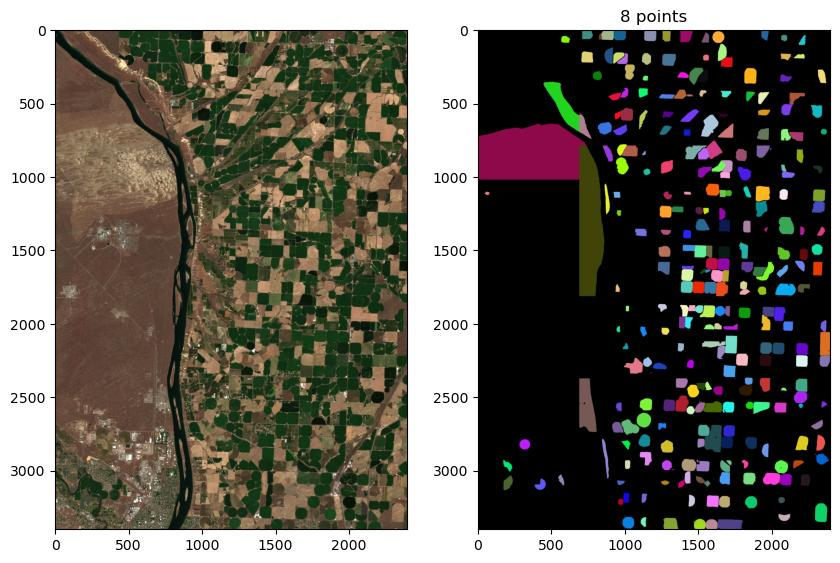

In [8]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={"points_per_side": 8, "spatial_overlap": 0.0},
)
run.monitor()

s2_raster = run.output["s2_raster"][0]
seg_raster_8pps = color_autoseg_masks(run.output["segmentation_mask"][0])

plot_autoseg_masks(s2_raster, {"8 points": seg_raster_8pps}, geom)

Even though the workflow was able to identify several fields, we see a lot of them were missed in this initial segmentation. With a larger region, each individual field is smaller and the workflow is not able to identify most several fields, because SAM is only able to segment those in which a point of the sampled grid falls. To improve the segmentation, we can increase the number of points sampled in the grid, which will increase the chances of sampling points inside the other fields.

Let's increase the number of points sampled in the grid to `points_per_side = 16` and run the workflow again.

Output()

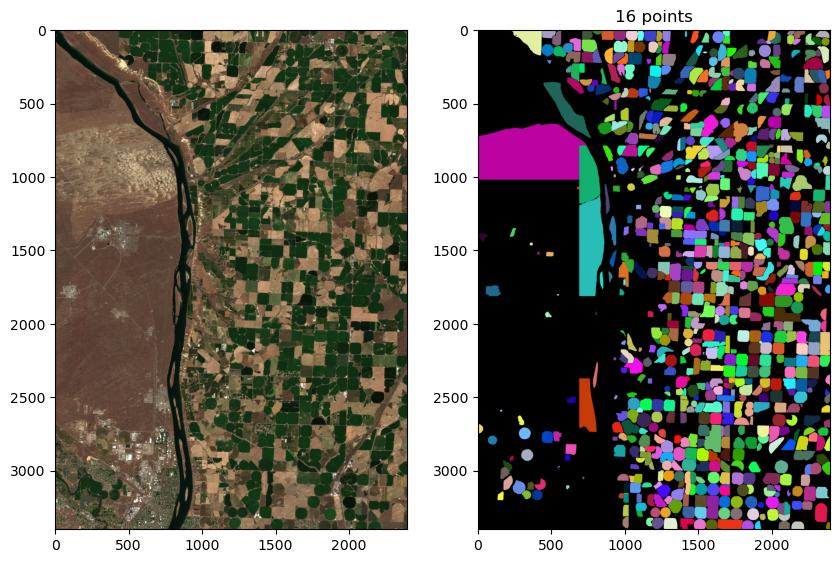

In [9]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 16,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

seg_raster_16pps = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(s2_raster, {"16 points": seg_raster_16pps}, geom)

This time the workflow was able to segment more fields. Let's further increase the number of points sampled in the grid to `points_per_side = 32` and see the results. 

Output()

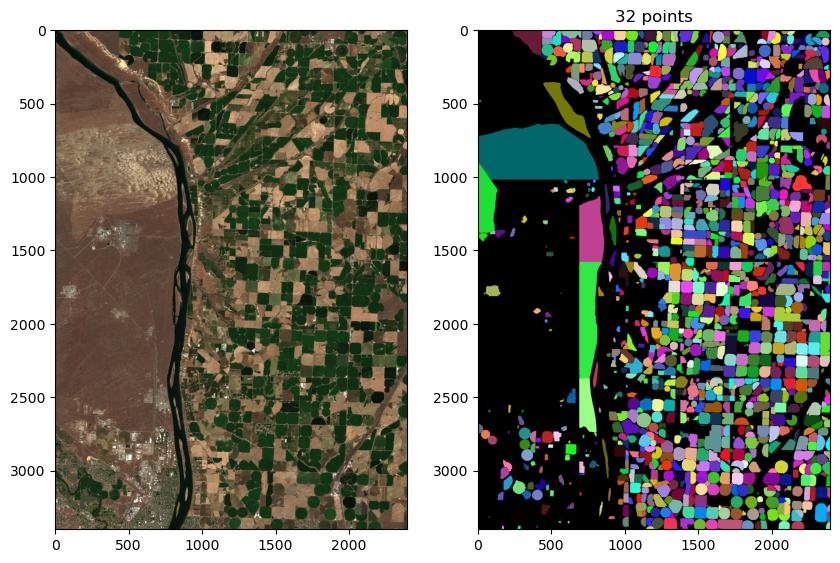

In [10]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 32,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

seg_raster_32pps = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(s2_raster, {"32 points": seg_raster_32pps}, geom)

With 32 points per side, most of the fields are identified. For comparison, we will plot all three results side by side:

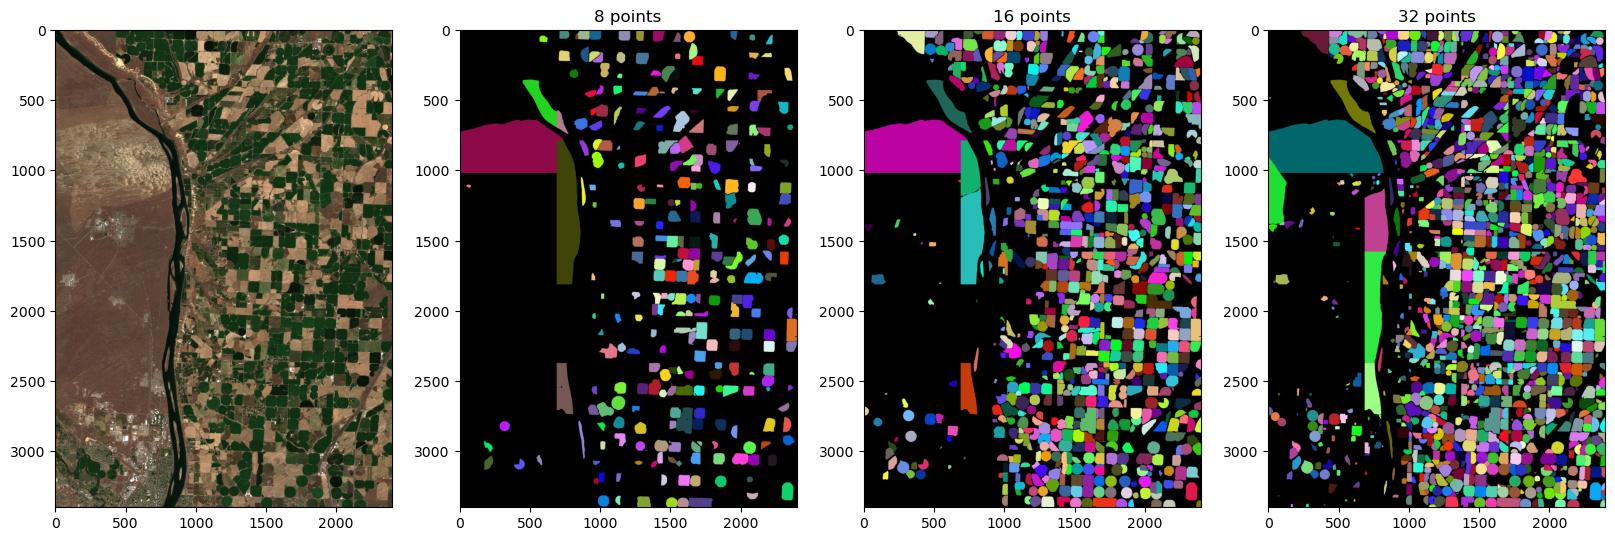

In [11]:
plot_autoseg_masks(
    s2_raster,
    {"8 points": seg_raster_8pps, "16 points": seg_raster_16pps, "32 points": seg_raster_32pps},
    geom,
    figsize=(20, 15),
)

As we can see, increasing the number of sampled points has a huge impact on the quality of the output mask. There is no golden rule for selecting the number of points, but we advise considering the size and characteristics of the entities of interest in the input region.

Despite the quality in segmenting the fields on the right part of the image, the workflow still has some limitations. It misses segmenting as a single entity the large land mass on the left part of the raster, as well as the river surrounding it. This is because the model is not able to segment large entities that span multiple chips, which is the case for those two. As chips are considered in isolation, output masks are limited to elements contained in a single chip.

Because we are processing chips, however, we might have cases in which one element falls in the border of the chip. To address such cases, we suggest increasing the `spatial_overlap`. Let's compare two workflow runs with `points_per_side = 8`, without spatial overlap and with an overlap of `0.5` (half the size of a chip).

Output()

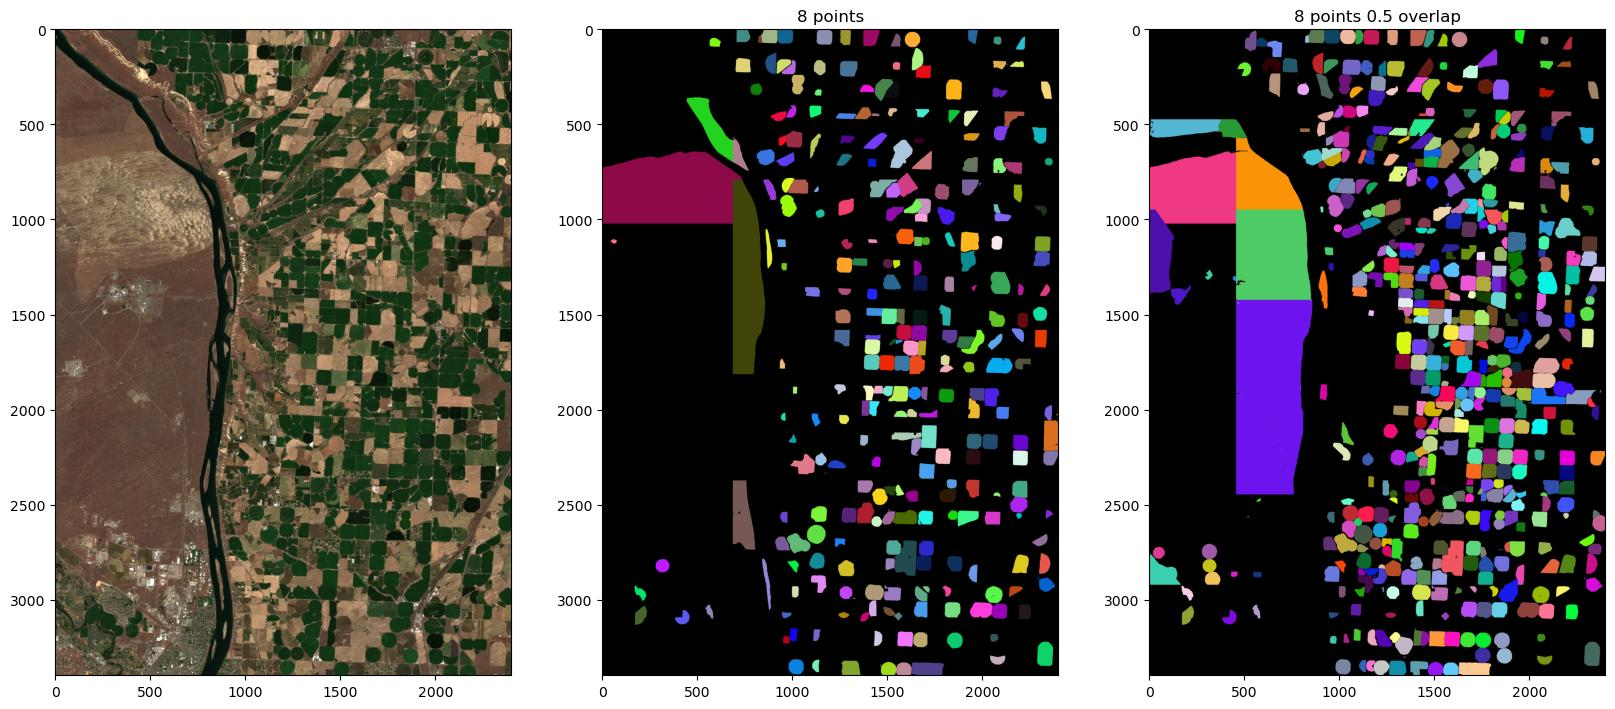

In [12]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 8,
        "spatial_overlap": 0.5,
    },
)
run.monitor()

seg_raster_8pps_half_overlap = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(
    s2_raster,
    {"8 points": seg_raster_8pps, "8 points 0.5 overlap": seg_raster_8pps_half_overlap},
    geom,
    figsize=(20, 15),
)

We can also experiment with the `n_crop_layers` parameter to break each chip into smaller images to be segmented individually.

Let's compare the results of the workflow with `n_crop_layers=0` and `n_crop_layers=1`, with the other two as their default values.

Output()

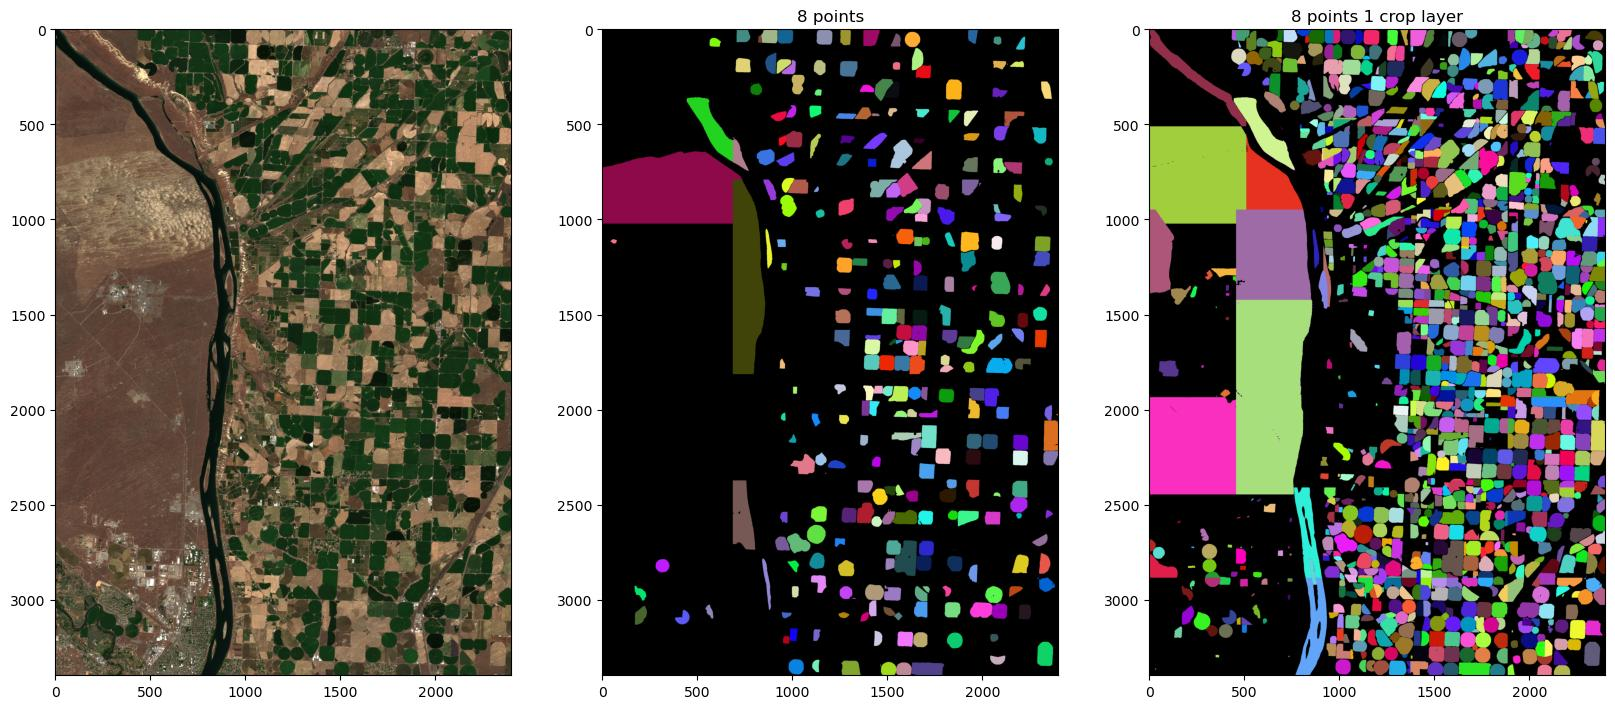

In [13]:
run = client.run(
    "farm_ai/segmentation/auto_segment_s2",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=time_range,
    parameters={
        "points_per_side": 8,
        "spatial_overlap": 0.5,
        "n_crop_layers": 1,
    },
)
run.monitor()

seg_raster_8pps_1croplayer = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(
    s2_raster,
    {"8 points": seg_raster_8pps, "8 points 1 crop layer": seg_raster_8pps_1croplayer},
    geom,
    figsize=(20, 15),
)